### In this notebook, we implement the Adams-Bashforth-Milne time-stepper to simulate the 1-dimensional motion of two charged point particles accelerated due to the Coulomb interaction.

#### Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### Just to get the code running, using the reaction
$$^{236}U \to ^{92}Kr + ^{141}Ba + 3n $$
#### (ignoring the neutrons). For future simulations, we know fragment particle numbers will not be integers. We use this reaction simply to have not-totally-unrealistic parameters with which to test the performance of the solver.
####
#### Simulation Parameters:

In [2]:
# Masses and charges
m1 = 92
m1 *= 931.5 # Express mass in MeV
q1 = 36
m2 = 141
m2 *= 931.5 # Express mass in MeV
q2 = 56

# Reduced mass
mu = m1*m2/(m1+m2)

# Coulomb constant (in MeV*fm)
k = 1.44; 

# Initial conditions
x01 = 15
x02 = -15
v01 = 0.05
v02 = -m1*v01/m2

# Energy
E = m1*(v01)**2/2+m2*(v02)**2/2+k*q1*q2/np.abs(x01-x02)

# Step Size and simulation time (fm/c). Number of steps.
dt = 0.06
T = 100
s = int(np.ceil(T/dt))

#### From energy conservation, it follows that the system obeys the differential equation 

$$\dot{x} = \left[ \frac{2}{\mu}\left(E-\frac{k q_1 q_2}{|x|}\right)\right]^{1/2}$$

#### We define a function to evaluate the RHS.

In [3]:
def deriv(x):
    return np.sqrt((2/mu)*(E-k*q1*q2/np.abs(x)))

#### To test the integration, compute a solution using the Forward Euler method.

In [4]:
# Data storage arrays for Forward Euler integration
xrelFE = np.zeros(s)
xrelFE[0] = x01-x02

# Forward Euler Time Stepper
for t in range(0,s-1):
    xrelFE[t+1] = xrelFE[t]+deriv(xrelFE[t])*dt;

#### Plot Forward Euler test case trajectories and energy conservation

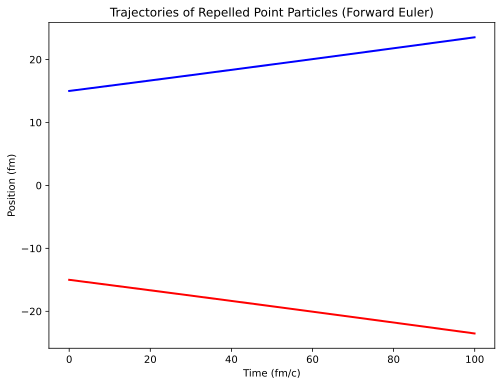

In [5]:
# Plotting configuration
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = [8, 6]

# Plot Forward Euler trajectories
plt.plot([dt*i for i in range(s)],xrelFE+x02,c="b",lw=2)
plt.plot([dt*i for i in range(s)],-(xrelFE-x01),c="r",lw=2)
plt.xlabel("Time (fm/c)")
plt.ylabel("Position (fm)")
plt.title("Trajectories of Repelled Point Particles (Forward Euler)")
plt.show()

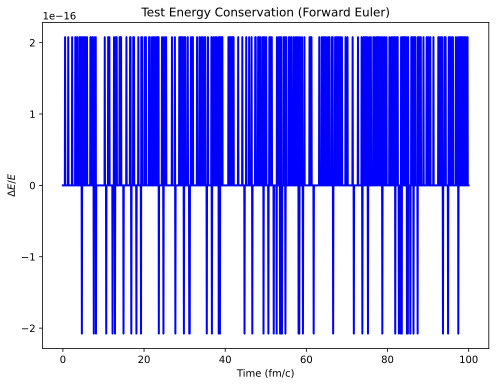

In [6]:
plt.plot([dt*i for i in range(s)],(E-[(1/2)*mu*deriv(x)**2 + k*q1*q2/np.abs(x) for x in xrelFE])/E,c="b",lw=2)
plt.xlabel("Time (fm/c)")
plt.ylabel("$\Delta E/E$")
plt.title("Test Energy Conservation (Forward Euler)")
plt.show()

#### Implement Adams-Bashforth-Milne time-stepper

In [7]:
xrelABM = np.zeros(s);
xrelABM[0:4] = xrelFE[0:4]; # One way to set up ICs.
#xrelABM(1:4)=[30, 30.004929363986545,30.01006178186523, 30.01539718418845];

ps = np.zeros(s); #WARNING: these start at 0. Arguably they should be initialized in some other way?
ms = np.zeros(s);
cs = np.zeros(s);
for t in range(3,s-1):

    # Predictor
    ps[t+1] = (xrelABM[t] + xrelABM[t-1])/2 + (dt/48)*(119*deriv(xrelABM[t]) - \
                     99*deriv(xrelABM[t-1]) + 69*deriv(xrelABM[t-2]) - 17*deriv(xrelABM[t-3]) );
        
    # Modifier 
    ms[t+1] = ps[t+1]-(161/170)*(ps[t]-cs[t]);
    
    # Corrector
    cs[t+1] = (xrelABM[t] + xrelABM[t-1])/2 + (dt/48)*(17*deriv(ms[t+1]) + \
        51*deriv(xrelABM[t]) + 3*deriv(xrelABM[t-1]) + deriv(xrelABM[t-2]) );

    xrelABM[t+1] = cs[t+1]+(9/170)*(ps[t+1]-cs[t+1]);

    

#### Plot ABM trajectories and energy conservation

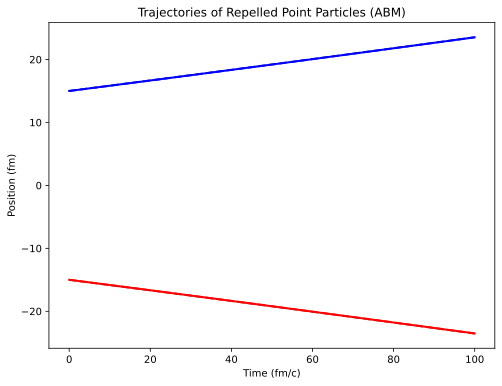

In [8]:
plt.plot([dt*i for i in range(s)],xrelABM+x02,c="b",lw=2)
plt.plot([dt*i for i in range(s)],-(xrelABM-x01),c="r",lw=2)
plt.plot([dt*i for i in range(s)],xrelFE+x02,"b--",lw=2)
plt.plot([dt*i for i in range(s)],-(xrelFE-x01),"r--",lw=2)
plt.xlabel("Time (fm/c)")
plt.ylabel("Position (fm)")
plt.title("Trajectories of Repelled Point Particles (ABM)")
plt.show()

# Note that Forward Euler trajectories are also plotted, but are indistinguishable from ABM at this scale

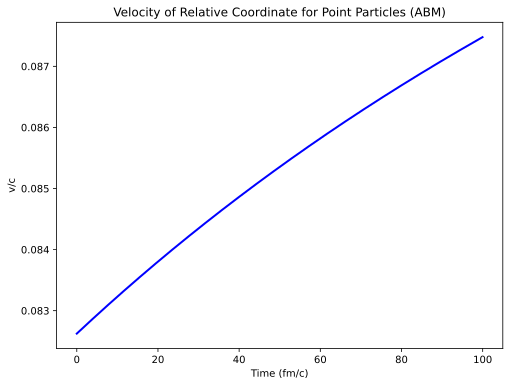

In [18]:
plt.plot([dt*i for i in range(s)],deriv(xrelABM),"b",lw=2)
plt.xlabel("Time (fm/c)")
plt.ylabel("v/c")
plt.title("Velocity of Relative Coordinate for Point Particles (ABM)")
plt.show()

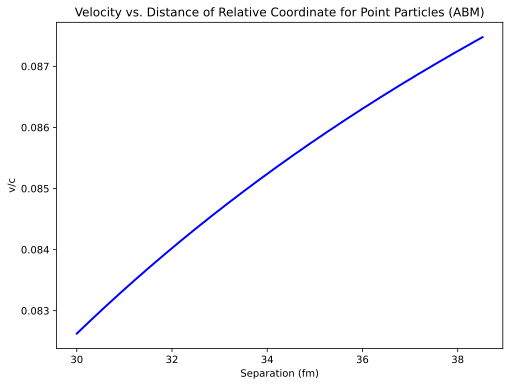

In [19]:
plt.plot(xrelABM,deriv(xrelABM),"b",lw=2)
plt.xlabel("Separation (fm)")
plt.ylabel("v/c")
plt.title("Velocity vs. Distance of Relative Coordinate for Point Particles (ABM)")
plt.show()

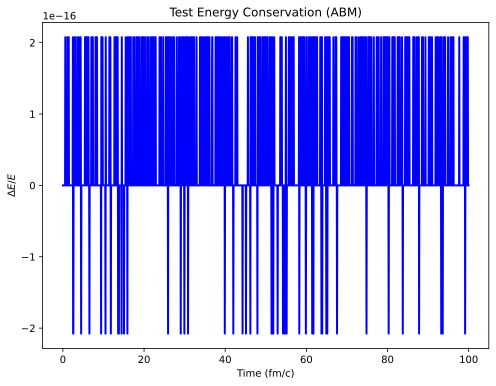

In [9]:
plt.plot([dt*i for i in range(s)],(E-[(1/2)*mu*deriv(x)**2 + k*q1*q2/np.abs(x) for x in xrelABM])/E,c="b",lw=2)
plt.xlabel("Time (fm/c)")
plt.ylabel("$\Delta E/E$")
plt.title("Test Energy Conservation (ABM)")
plt.show()

#### We compare the performance of the two solvers using the largest fractional difference, defined as 
$$\frac{\text{max}_t|x_{FE}(t)-x_{ABM}(t)|}{\text{max}_t |x_{ABM}(t)|}$$

In [10]:
np.max( np.abs(xrelFE-xrelABM) )/np.max( np.abs(xrelABM) )

3.880571006433767e-06

#### Using Mathematica, it is also possible to solve explicitly for $t(x)$. Plugging in the numbers specific to our problem, we get
$$t(x) = 0.588153 \sqrt{x} \sqrt{273.786 x-2903.04}+103.19
   \tanh
   ^{-1}\left(\sqrt{\frac{x-10.6033}{x}}\right)-349
   .306$$
   
#### This expression can be numerically inverted to find $x(t)$ for all $t$ in [dt*i for i in range(s)]. 

#### We copy the results of this numerical inversion below, and call these numbers the "analytical" solution.

In [13]:
xrelanalytical=np.array([30., 30.004957558752633, 30.00991534134419, 
 30.01487334770072, 30.01983157774832, 
 30.024790031413072, 30.029748708621145, 
 30.034707609298717, 30.039666733371998, 
 30.044626080767237, 30.04958565141072, 
 30.05454544522875, 30.059505462147683, 
 30.064465702093884, 30.069426164993782, 
 30.074386850773823, 30.079347759360473, 
 30.08430889068026, 30.08927024465972, 
 30.094231821225428, 30.099193620304007, 
 30.104155641822086, 30.109117885706357, 
 30.11408035188352, 30.119043040280324, 
 30.12400595082355, 30.128969083439987, 
 30.133932438056497, 30.13889601459995, 
 30.14385981299725, 30.148823833175335, 
 30.15378807506119, 30.158752538581812, 
 30.16371722366424, 30.16868213023555, 
 30.173647258222843, 30.17861260755325, 
 30.18357817815396, 30.188543969952157, 
 30.193509982875085, 30.198476216850008, 
 30.20344267180423, 30.208409347665082, 
 30.21337624435993, 30.218343361816178, 
 30.223310699961246, 30.22827825872261, 
 30.233246038027758, 30.238214037804216, 
 30.243182257979555, 30.248150698481357, 
 30.253119359237257, 30.258088240174917, 
 30.26305734122201, 30.268026662306276, 
 30.27299620335547, 30.277965964297366, 
 30.282935945059798, 30.28790614557062, 
 30.292876565757705, 30.297847205548987, 
 30.3028180648724, 30.30778914365593, 
 30.31276044182759, 30.317731959315438, 
 30.32270369604754, 30.327675651952017, 
 30.332647826957007, 30.337620220990686, 
 30.34259283398125, 30.347565665856962, 
 30.352538716546068, 30.3575119859769, 
 30.36248547407777, 30.367459180777054, 
 30.37243310600315, 30.3774072496845, 
 30.382381611749555, 30.38735619212682, 
 30.392330990744817, 30.39730600753211, 
 30.402281242417285, 30.40725669532898, 
 30.412232366195827, 30.417208254946537, 
 30.42218436150982, 30.427160685814428, 
 30.432137227789145, 30.43711398736277, 
 30.442090964464175, 30.44706815902223, 
 30.452045570965836, 30.457023200223947, 
 30.462001046725536, 30.4669791103996, 
 30.47195739117518, 30.476935888981345, 
 30.481914603747207, 30.486893535401872, 
 30.49187268387453, 30.496852049094365, 
 30.50183163099061, 30.50681142949251, 
 30.511791444529365, 30.5167716760305, 
 30.521752123925268, 30.526732788143043, 
 30.53171366861325, 30.536694765265338, 
 30.541676078028786, 30.54665760683309, 
 30.551639351607818, 30.556621312282527, 
 30.561603488786815, 30.566585881050337, 
 30.57156848900275, 30.576551312573756, 
 30.581534351693083, 30.586517606290496, 
 30.591501076295785, 30.596484761638777, 
 30.601468662249324, 30.606452778057317, 
 30.61143710899267, 30.616421654985324, 
 30.62140641596528, 30.626391391862537, 
 30.63137658260714, 30.636361988129153, 
 30.6413476083587, 30.6463334432259, 
 30.651319492660928, 30.656305756593984, 
 30.661292234955294, 30.66627892767512, 
 30.671265834683744, 30.6762529559115, 
 30.681240291288734, 30.68622784074584, 
 30.691215604213216, 30.696203581621337, 
 30.701191772900643, 30.706180177981675, 
 30.711168796794954, 30.716157629271056, 
 30.721146675340574, 30.726135934934156, 
 30.731125407982443, 30.73611509441614, 
 30.741104994165966, 30.74609510716268, 
 30.75108543333707, 30.75607597261995, 
 30.761066724942157, 30.76605769023458, 
 30.77104886842812, 30.776040259453726, 
 30.781031863242365, 30.786023679725023, 
 30.79101570883275, 30.79600795049659, 
 30.80100040464764, 30.805993071217035, 
 30.810985950135915, 30.815979041335464, 
 30.82097234474691, 30.825965860301487, 
 30.83095958793047, 30.835953527565163, 
 30.84094767913691, 30.84594204257706, 
 30.850936617817037, 30.855931404788244, 
 30.860926403422155, 30.86592161365025, 
 30.87091703540405, 30.8759126686151, 
 30.880908513214983, 30.885904569135313, 
 30.89090083630771, 30.89589731466388, 
 30.900894004135488, 30.90589090465428, 
 30.910888016152022, 30.915885338560493, 
 30.920882871811525, 30.92588061583696, 
 30.93087857056868, 30.9358767359386, 
 30.940875111878658, 30.945873698320842, 
 30.950872495197142, 30.95587150243959, 
 30.960870719980235, 30.965870147751193, 
 30.97086978568458, 30.97586963371254, 
 30.98086969176726, 30.98586995978095, 
 30.990870437685857, 30.99587112541425, 
 31.00087202289843, 31.005873130070732, 
 31.01087444686351, 31.01587597320917, 
 31.020877709040125, 31.025879654288826, 
 31.03088180888776, 31.03588417276943, 
 31.040886745866384, 31.045889528111182, 
 31.050892519436445, 31.055895719774785, 
 31.06089912905886, 31.065902747221376, 
 31.070906574195046, 31.075910609912622, 
 31.080914854306872, 31.085919307310615, 
 31.090923968856686, 31.09592883887795, 
 31.100933917307316, 31.105939204077686, 
 31.110944699122044, 31.115950402373365, 
 31.120956313764662, 31.125962433228988, 
 31.130968760699403, 31.135975296109034, 
 31.14098203939099, 31.145988990478457, 
 31.150996149304618, 31.15600351580269, 
 31.161011089905934, 31.166018871547617, 
 31.171026860661073, 31.176035057179615, 
 31.181043461036626, 31.186052072165506, 
 31.191060890499685, 31.19606991597261, 
 31.201079148517774, 31.206088588068692, 
 31.21109823455891, 31.216108087922002, 
 31.221118148091573, 31.226128415001245, 
 31.231138888584702, 31.236149568775613, 
 31.241160455507703, 31.246171548714727, 
 31.25118284833047, 31.25619435428873, 
 31.261206066523343, 31.266217984968172, 
 31.27123010955713, 31.276242440224113, 
 31.281254976903107, 31.286267719528063, 
 31.291280668033014, 31.29629382235199, 
 31.30130718241907, 31.306320748168343, 
 31.311334519533922, 31.316348496449994, 
 31.321362678850726, 31.326377066670343, 
 31.33139165984306, 31.336406458303188, 
 31.341421461985, 31.34643667082284, 
 31.351452084751045, 31.356467703704027, 
 31.36148352761619, 31.36649955642198, 
 31.371515790055874, 31.37653222845237, 
 31.381548871546, 31.386565719271314, 
 31.391582771562916, 31.39660002835541, 
 31.40161748958346, 31.406635155181725, 
 31.41165302508491, 31.416671099227752, 
 31.421689377545004, 31.42670785997145, 
 31.431726546441926, 31.436745436891258, 
 31.441764531254343, 31.44678382946606, 
 31.45180333146136, 31.456823037175198, 
 31.461842946542557, 31.466863059498454, 
 31.471883375977935, 31.47690389591608, 
 31.481924619247987, 31.486945545908792, 
 31.49196667583365, 31.49698800895775, 
 31.5020095452163, 31.50703128454455, 
 31.512053226877782, 31.517075372151282, 
 31.522097720300387, 31.52712027126046, 
 31.53214302496688, 31.53716598135506, 
 31.54218914036044, 31.547212501918505, 
 31.552236065964742, 31.557259832434674, 
 31.562283801263867, 31.567307972387898, 
 31.57233234574239, 31.577356921262965, 
 31.58238169888531, 31.587406678545097, 
 31.592431860178074, 31.59745724371998, 
 31.602482829106602, 31.60750861627374, 
 31.612534605157244, 31.61756079569296, 
 31.622587187816794, 31.627613781464667, 
 31.632640576572516, 31.637667573076335, 
 31.642694770912108, 31.647722170015886, 
 31.652749770323716, 31.657777571771692, 
 31.662805574295927, 31.667833777832566, 
 31.672862182317786, 31.67789078768778, 
 31.682919593878776, 31.68794860082703, 
 31.69297780846882, 31.698007216740482, 
 31.703036825578323, 31.708066634918723, 
 31.713096644698073, 31.718126854852795, 
 31.723157265319344, 31.728187876034198, 
 31.73321868693385, 31.738249697954842, 
 31.743280909033736, 31.748312320107114, 
 31.75334393111159, 31.75837574198382, 
 31.763407752660456, 31.768439963078215, 
 31.773472373173806, 31.77850498288399, 
 31.783537792145555, 31.788570800895304, 
 31.793604009070066, 31.798637416606713, 
 31.803671023442135, 31.808704829513243, 
 31.81373883475699, 31.818773039110358, 
 31.823807442510322, 31.82884204489394, 
 31.833876846198248, 31.838911846360332, 
 31.843947045317314, 31.848982443006314, 
 31.854018039364508, 31.859053834329085, 
 31.864089827837272, 31.8691260198263, 
 31.874162410233456, 31.879198998996042, 
 31.88423578605138, 31.889272771336824, 
 31.894309954789772, 31.899347336347617, 
 31.904384915947805, 31.9094226935278, 
 31.914460669025082, 31.9194988423772, 
 31.924537213521667, 31.929575782396082, 
 31.93461454893802, 31.939653513085133, 
 31.944692674775055, 31.949732033945484, 
 31.95477159053412, 31.959811344478698, 
 31.964851295716993, 31.969891444186782, 
 31.974931789825874, 31.97997233257213, 
 31.985013072363422, 31.990054009137626, 
 31.99509514283268, 32.00013647338654, 
 32.00517800073719, 32.010219724822605, 
 32.01526164558085, 32.02030376294996, 
 32.02534607686803, 32.03038858727318, 
 32.035431294103546, 32.04047419729728, 
 32.0455172967926, 32.0505605925277, 
 32.055604084440844, 32.0606477724703, 
 32.06569165655436, 32.07073573663136, 
 32.075780012639655, 32.08082448451762, 
 32.085869152203664, 32.09091401563622, 
 32.09595907475375, 32.101004329494735, 
 32.106049779797694, 32.111095425601164, 
 32.116141266843705, 32.12118730346393, 
 32.12623353540044, 32.13127996259188, 
 32.136326584976935, 32.141373402494295, 
 32.146420415082694, 32.151467622680876, 
 32.15651502522763, 32.16156262266174, 
 32.16661041492207, 32.17165840194745, 
 32.176706583676776, 32.18175496004896, 
 32.18680353100293, 32.191852296477656, 
 32.19690125641213, 32.20195041074537, 
 32.20699975941641, 32.212049302364335, 
 32.217099039528215, 32.2221489708472, 
 32.227199096260414, 32.23224941570705, 
 32.237299929126294, 32.242350636457374, 
 32.247401537639554, 32.252452632612105, 
 32.25750392131433, 32.26255540368556, 
 32.26760707966517, 32.272658949192525, 
 32.27771101220703, 32.28276326864814, 
 32.287815718455306, 32.29286836156802, 
 32.2979211979258, 32.30297422746817, 
 32.30802745013471, 32.31308086586502, 
 32.3181344745987, 32.32318827627541, 
 32.3282422708348, 32.333296458216594, 
 32.338350838360505, 32.34340541120627, 
 32.34846017669366, 32.35351513476251, 
 32.358570285352606, 32.36362562840383, 
 32.36868116385604, 32.373736891649145, 
 32.37879281172308, 32.383848924017805, 
 32.38890522847328, 32.39396172502954, 
 32.3990184136266, 32.404075294204524, 
 32.409132366703396, 32.41418963106333, 
 32.41924708722445, 32.42430473512694, 
 32.429362574710964, 32.434420605916756, 
 32.43947882868454, 32.444537242954596, 
 32.449595848667194, 32.45465464576267, 
 32.459713634181355, 32.46477281386362, 
 32.469832184749855, 32.47489174678049, 
 32.479951499895954, 32.48501144403673, 
 32.490071579143304, 32.4951319051562, 
 32.50019242201596, 32.50525312966316, 
 32.5103140280384, 32.515375117082314, 
 32.52043639673552, 32.52549786693872, 
 32.530559527632604, 32.5356213787579, 
 32.54068342025535, 32.54574565206573, 
 32.55080807412986, 32.55587068638854, 
 32.56093348878265, 32.565996481253045, 
 32.57105966374063, 32.576123036186345, 
 32.58118659853114, 32.58625035071597, 
 32.591314292681886, 32.59637842436988, 
 32.60144274572102, 32.60650725667639, 
 32.61157195717708, 32.61663684716423, 
 32.621701926579, 32.62676719536256, 
 32.63183265345612, 32.636898300800915, 
 32.6419641373382, 32.64703016300926, 
 32.65209637775539, 32.65716278151794, 
 32.662229374238244, 32.6672961558577, 
 32.672363126317705, 32.6774302855597, 
 32.682497633525145, 32.68756517015551, 
 32.69263289539232, 32.69770080917708, 
 32.70276891145137, 32.70783720215676, 
 32.71290568123488, 32.71797434862732, 
 32.72304320427578, 32.728112248121924, 
 32.733181480107454, 32.73825090017411, 
 32.74332050826365, 32.748390304317844, 
 32.75346028827851, 32.75853046008748, 
 32.763600819686616, 32.76867136701777, 
 32.77374210202288, 32.77881302464387, 
 32.78388413482267, 32.7889554325013, 
 32.794026917621736, 32.79909859012603, 
 32.80417044995621, 32.809242497054385, 
 32.814314731362636, 32.81938715282311, 
 32.82445976137794, 32.82953255696932, 
 32.83460553953945, 32.839678709030565, 
 32.844752065384895, 32.849825608544734, 
 32.854899338452384, 32.85997325505016, 
 32.86504735828043, 32.87012164808555, 
 32.875196124407935, 32.88027078719, 
 32.88534563637419, 32.890420671903, 
 32.89549589371891, 32.900571301764444, 
 32.90564689598215, 32.910722676314606, 
 32.915798642704395, 32.92087479509416, 
 32.9259511334265, 32.931027657644144, 
 32.936104367689744, 32.94118126350603, 
 32.94625834503576, 32.95133561222167, 
 32.95641306500657, 32.96149070333328, 
 32.96656852714464, 32.97164653638348, 
 32.97672473099273, 32.981803110915294, 
 32.9868816760941, 32.991960426472104, 
 32.997039361992314, 33.002118482597716, 
 33.00719778823136, 33.012277278836294, 
 33.017356954355606, 33.02243681473241, 
 33.02751685990982, 33.032597089831, 
 33.03767750443913, 33.042758103677414, 
 33.04783888748908, 33.05291985581737, 
 33.05800100860557, 33.06308234579698, 
 33.06816386733491, 33.07324557316274, 
 33.07832746322381, 33.08340953746152, 
 33.08849179581931, 33.093574238240606, 
 33.098656864668875, 33.10373967504763, 
 33.10882266932036, 33.11390584743062, 
 33.11898920932198, 33.12407275493801, 
 33.12915648422234, 33.1342403971186, 
 33.13932449357044, 33.14440877352156, 
 33.149493236915646, 33.15457788369645, 
 33.15966271380772, 33.16474772719323, 
 33.16983292379679, 33.17491830356222, 
 33.18000386643339, 33.18508961235415, 
 33.19017554126841, 33.19526165312008, 
 33.200347947853125, 33.2054344254115, 
 33.210521085739195, 33.21560792878025, 
 33.22069495447868, 33.225782162778565, 
 33.23086955362398, 33.23595712695905, 
 33.241044882727905, 33.2461328208747, 
 33.251220941343625, 33.25630924407888, 
 33.261397729024694, 33.26648639612533, 
 33.271575245325046, 33.27666427656816, 
 33.281753489799, 33.2868428849619, 
 33.291932462001235, 33.2970222208614, 
 33.302112161486804, 33.30720228382191, 
 33.31229258781117, 33.31738307339907, 
 33.32247374053013, 33.32756458914889, 
 33.33265561919989, 33.33774683062772, 
 33.342838223377, 33.34792979739235, 
 33.353021552618415, 33.358113488999884, 
 33.36320560648145, 33.36829790500783, 
 33.37339038452378, 33.37848304497407, 
 33.383575886303475, 33.388668908456836, 
 33.393762111378976, 33.39885549501477, 
 33.403949059309085, 33.40904280420685, 
 33.41413672965299, 33.419230835592444, 
 33.42432512197021, 33.42941958873131, 
 33.43451423582072, 33.439609063183525, 
 33.44470407076478, 33.449799258509586, 
 33.454894626363064, 33.45999017427035, 
 33.46508590217661, 33.47018181002704, 
 33.47527789776683, 33.48037416534123, 
 33.48547061269549, 33.49056723977489, 
 33.49566404652474, 33.50076103289035, 
 33.50585819881709, 33.5109555442503, 
 33.51605306913541, 33.521150773417816, 
 33.52624865704297, 33.531346719956325, 
 33.53644496210338, 33.541543383429634, 
 33.546641983880626, 33.55174076340191, 
 33.556839721939056, 33.56193885943769, 
 33.5670381758434, 33.57213767110186, 
 33.57723734515873, 33.5823371979597, 
 33.587437229450494, 33.59253743957685, 
 33.59763782828452, 33.60273839551929, 
 33.607839141226975, 33.612940065353406, 
 33.618041167844424, 33.6231424486459, 
 33.62824390770375, 33.63334554496388, 
 33.638447360372254, 33.6435493538748, 
 33.64865152541755, 33.65375387494649, 
 33.65885640240766, 33.663959107747104, 
 33.66906199091092, 33.6741650518452, 
 33.67926829049607, 33.68437170680968, 
 33.6894753007322, 33.69457907220982, 
 33.69968302118876, 33.70478714761524, 
 33.70989145143555, 33.71499593259594, 
 33.72010059104274, 33.72520542672227, 
 33.73031043958088, 33.73541562956493, 
 33.740520996620845, 33.745626540695014, 
 33.75073226173388, 33.755838159683925, 
 33.76094423449162, 33.766050486103474, 
 33.77115691446601, 33.77626351952579, 
 33.781370301229394, 33.78647725952341, 
 33.79158439435446, 33.79669170566917, 
 33.801799193414226, 33.80690685753631, 
 33.81201469798213, 33.81712271469841, 
 33.822230907631905, 33.8273392767294, 
 33.83244782193767, 33.837556543203576, 
 33.842665440473915, 33.84777451369558, 
 33.852883762815445, 33.85799318778043, 
 33.863102788537475, 33.868212565033495, 
 33.873322517215506, 33.878432645030486, 
 33.88354294842546, 33.88865342734747, 
 33.893764081743576, 33.89887491156087, 
 33.90398591674646, 33.909097097247475, 
 33.91420845301106, 33.9193199839844, 
 33.924431690114695, 33.92954357134916, 
 33.934655627635024, 33.93976785891957, 
 33.94488026515007, 33.94999284627384, 
 33.95510560223819, 33.96021853299049, 
 33.96533163847811, 33.97044491864845, 
 33.97555837344892, 33.98067200282695, 
 33.985785806730014, 33.99089978510559, 
 33.99601393790118, 34.001128265064324, 
 34.00624276654255, 34.01135744228343, 
 34.01647229223458, 34.0215873163436, 
 34.02670251455812, 34.0318178868258, 
 34.036933433094326, 34.04204915331139, 
 34.04716504742472, 34.052281115382065, 
 34.057397357131194, 34.06251377261989, 
 34.06763036179595, 34.072747124607226, 
 34.07786406100156, 34.08298117092684, 
 34.08809845433095, 34.09321591116182, 
 34.09833354136738, 34.103451344895596, 
 34.10856932169445, 34.113687471711955, 
 34.11880579489614, 34.12392429119504, 
 34.12904296055673, 34.134161802929306, 
 34.139280818260886, 34.144400006499595, 
 34.14951936759359, 34.15463890149106, 
 34.15975860814021, 34.16487848748923, 
 34.16999853948639, 34.17511876407995, 
 34.18023916121819, 34.18535973084942, 
 34.19048047292197, 34.195601387384194, 
 34.20072247418446, 34.20584373327116, 
 34.21096516459271, 34.21608676809754, 
 34.22120854373412, 34.22633049145092, 
 34.23145261119645, 34.23657490291923, 
 34.24169736656779, 34.246820002090715, 
 34.251942809436564, 34.257065788553966, 
 34.26218893939155, 34.26731226189795, 
 34.272435756021856, 34.277559421711935, 
 34.28268325891693, 34.287807267585556, 
 34.29293144766658, 34.29805579910879, 
 34.30318032186096, 34.30830501587191, 
 34.31342988109051, 34.3185549174656, 
 34.323680124946065, 34.328805503480815, 
 34.33393105301877, 34.339056773508894, 
 34.34418266490013, 34.34930872714149, 
 34.354434960181976, 34.35956136397061, 
 34.36468793845647, 34.36981468358861, 
 34.374941599316124, 34.38006868558814, 
 34.38519594235379, 34.390323369562225, 
 34.395450967162645, 34.400578735104226, 
 34.405706673336205, 34.410834781807814, 
 34.41596306046833, 34.42109150926702, 
 34.42622012815321, 34.431348917076214, 
 34.43647787598538, 34.441607004830075, 
 34.4467363035597, 34.45186577212365, 
 34.456995410471364, 34.462125218552295, 
 34.46725519631591, 34.4723853437117, 
 34.4775156606892, 34.48264614719792, 
 34.48777680318743, 34.49290762860731, 
 34.498038623407155, 34.503169787536585, 
 34.508301120945234, 34.513432623582766, 
 34.51856429539887, 34.523696136343226, 
 34.52882814636559, 34.53396032541568, 
 34.53909267344326, 34.54422519039812, 
 34.54935787623008, 34.55449073088896, 
 34.5596237543246, 34.56475694648687, 
 34.56989030732566, 34.575023836790876, 
 34.580157534832445, 34.58529140140033, 
 34.590425436444505, 34.595559639914946, 
 34.60069401176167, 34.60582855193473, 
 34.610963260384146, 34.61609813706001, 
 34.621233181912416, 34.62636839489149, 
 34.63150377594735, 34.63663932503017, 
 34.64177504209011, 34.64691092707738, 
 34.65204697994219, 34.65718320063479, 
 34.66231958910543, 34.66745614530439, 
 34.67259286918197, 34.6777297606885, 
 34.68286681977431, 34.688004046389764, 
 34.69314144048525, 34.69827900201116, 
 34.70341673091794, 34.70855462715599, 
 34.71369269067581, 34.71883092142789, 
 34.7239693193627, 34.72910788443079, 
 34.73424661658271, 34.739385515768994, 
 34.744524581940254, 34.74966381504709, 
 34.75480321504014, 34.75994278187002, 
 34.765082515487435, 34.770222415843044, 
 34.77536248288756, 34.780502716571725, 
 34.78564311684627, 34.79078368366198, 
 34.79592441696962, 34.80106531672002, 
 34.806206382864, 34.8113476153524, 
 34.81648901413612, 34.82163057916602, 
 34.82677231039302, 34.83191420776804, 
 34.83705627124205, 34.842198500766, 
 34.847340896290895, 34.85248345776775, 
 34.857626185147566, 34.86276907838143, 
 34.867912137420376, 34.87305536221553, 
 34.87819875271798, 34.883342308878866, 
 34.88848603064933, 34.89362991798057, 
 34.898773970823726, 34.90391818913006, 
 34.90906257285078, 34.91420712193713, 
 34.9193518363404, 34.92449671601186, 
 34.92964176090284, 34.93478697096465, 
 34.93993234614867, 34.94507788640625, 
 34.95022359168878, 34.955369461947676, 
 34.960515497134374, 34.96566169720031, 
 34.970808062096964, 34.97595459177582, 
 34.98110128618839, 34.986248145286204, 
 34.99139516902083, 34.99654235734379, 
 35.001689710206726, 35.00683722756123, 
 35.01198490935891, 35.01713275555144, 
 35.02228076609047, 35.02742894092769, 
 35.032577280014834, 35.03772578330359, 
 35.04287445074574, 35.04802328229303, 
 35.053172277897254, 35.05832143751022, 
 35.06347076108375, 35.068620248569694, 
 35.073769899919924, 35.0789197150863, 
 35.08406969402076, 35.08921983667521, 
 35.09437014300159, 35.09952061295187, 
 35.10467124647804, 35.1098220435321, 
 35.11497300406606, 35.12012412803198, 
 35.125275415381914, 35.130426866067936, 
 35.13557848004216, 35.140730257256706, 
 35.1458821976637, 35.15103430121532, 
 35.156186567863735, 35.161338997561145, 
 35.16649159025976, 35.17164434591183, 
 35.176797264469606, 35.18195034588537, 
 35.18710359011141, 35.19225699710006, 
 35.197410566803626, 35.20256429917448, 
 35.207718194165, 35.21287225172756, 
 35.21802647181459, 35.223180854378526, 
 35.228335399371794, 35.233490106746885, 
 35.23864497645629, 35.24380000845252, 
 35.24895520268809, 35.254110559115546, 
 35.25926607768748, 35.264421758356455, 
 35.269577601075085, 35.274733605795994, 
 35.27988977247183, 35.28504610105527, 
 35.29020259149897, 35.295359243755655, 
 35.300516057778026, 35.305673033518836, 
 35.31083017093085, 35.31598746996684, 
 35.32114493057961, 35.32630255272196, 
 35.33146033634675, 35.33661828140683, 
 35.34177638785507, 35.34693465564436, 
 35.352093084727635, 35.35725167505781, 
 35.36241042658783, 35.36756933927068, 
 35.37272841305934, 35.37788764790683, 
 35.383047043766176, 35.38820660059043, 
 35.39336631833264, 35.3985261969459, 
 35.40368623638334, 35.40884643659804, 
 35.414006797543166, 35.41916731917188, 
 35.42432800143737, 35.42948884429282, 
 35.434649847691446, 35.43981101158651, 
 35.44497233593123, 35.45013382067892, 
 35.455295465782854, 35.46045727119636, 
 35.465619236872755, 35.4707813627654, 
 35.47594364882765, 35.48110609501291, 
 35.4862687012746, 35.4914314675661, 
 35.496594393840915, 35.50175748005247, 
 35.50692072615426, 35.51208413209979, 
 35.51724769784258, 35.52241142333616, 
 35.527575308534104, 35.532739353389985, 
 35.53790355785739, 35.54306792188996, 
 35.54823244544129, 35.55339712846507, 
 35.55856197091495, 35.563726972744625, 
 35.56889213390781, 35.574057454358226, 
 35.57922293404962, 35.58438857293577, 
 35.58955437097044, 35.594720328107435, 
 35.5998864443006, 35.60505271950375, 
 35.61021915367077, 35.6153857467555, 
 35.62055249871186, 35.62571940949377, 
 35.630886479055135, 35.63605370734995, 
 35.641221094332145, 35.64638863995574, 
 35.651556344174715, 35.656724206943124, 
 35.66189222821499, 35.66706040794439, 
 35.672228746085395, 35.67739724259212, 
 35.68256589741868, 35.687734710519194, 
 35.692903681847845, 35.69807281135879, 
 35.70324209900624, 35.708411544744386, 
 35.713581148527474, 35.71875091030974, 
 35.72392083004546, 35.72909090768892, 
 35.734261143194416, 35.73943153651628, 
 35.74460208760885, 35.74977279642646, 
 35.754943662923544, 35.760114687054454, 
 35.76528586877362, 35.770457208035474, 
 35.77562870479446, 35.78080035900504, 
 35.78597217062173, 35.79114413959903, 
 35.79631626589144, 35.80148854945354, 
 35.80666099023985, 35.81183358820497, 
 35.81700634330351, 35.82217925549008, 
 35.827352324719286, 35.832525550945824, 
 35.83769893412434, 35.84287247420953, 
 35.8480461711561, 35.85322002491877, 
 35.8583940354523, 35.863568202711434, 
 35.86874252665097, 35.87391700722569, 
 35.87909164439042, 35.8842664381, 
 35.889441388309265, 35.894616494973114, 
 35.89979175804641, 35.90496717748408, 
 35.91014275324103, 35.91531848527223, 
 35.92049437353262, 35.92567041797718, 
 35.93084661856092, 35.93602297523886, 
 35.94119948796604, 35.946376156697475, 
 35.95155298138827, 35.9567299619935, 
 35.96190709846829, 35.96708439076773, 
 35.972261838847, 35.977439442661236, 
 35.98261720216563, 35.987795117315365, 
 35.99297318806566, 35.99815141437177, 
 36.00332979618892, 36.00850833347238, 
 36.01368702617745, 36.01886587425942, 
 36.02404487767364, 36.02922403637541, 
 36.034403350320126, 36.03958281946313, 
 36.04476244375985, 36.04994222316567, 
 36.05512215763604, 36.060302247126394, 
 36.06548249159221, 36.070662890988956, 
 36.07584344527215, 36.081024154397305, 
 36.086205018319944, 36.09138603699565, 
 36.09656721037998, 36.10174853842851, 
 36.10693002109688, 36.112111658340694, 
 36.117293450115596, 36.122475396377254, 
 36.12765749708136, 36.132839752183585, 
 36.138022161639654, 36.14320472540531, 
 36.148387443436285, 36.15357031568837, 
 36.15875334211733, 36.16393652267898, 
 36.16911985732914, 36.17430334602364, 
 36.17948698871835, 36.18467078536914, 
 36.189854735931895, 36.19503884036253, 
 36.20022309861696, 36.20540751065116, 
 36.210592076421065, 36.21577679588266, 
 36.22096166899195, 36.22614669570495, 
 36.23133187597767, 36.2365172097662, 
 36.24170269702657, 36.24688833771489, 
 36.25207413178725, 36.25726007919979, 
 36.262446179908615, 36.26763243386991, 
 36.27281884103983, 36.27800540137458, 
 36.283192114830356, 36.28837898136339, 
 36.29356600092993, 36.29875317348621, 
 36.303940498988545, 36.30912797739321, 
 36.31431560865652, 36.319503392734816, 
 36.32469132958443, 36.329879419161735, 
 36.3350676614231, 36.34025605632495, 
 36.34544460382369, 36.35063330387573, 
 36.35582215643757, 36.36101116146566, 
 36.36620031891647, 36.37138962874652, 
 36.37657909091233, 36.38176870537043, 
 36.38695847207739, 36.392148390989774, 
 36.39733846206417, 36.4025286852572, 
 36.40771906052547, 36.41290958782565, 
 36.41810026711437, 36.42329109834833, 
 36.428482081484205, 36.43367321647872, 
 36.43886450328859, 36.44405594187059, 
 36.44924753218146, 36.45443927417798, 
 36.45963116781695, 36.4648232130552, 
 36.470015409849545, 36.475207758156834, 
 36.480400257933944, 36.48559290913775, 
 36.49078571172517, 36.495978665653084, 
 36.50117177087847, 36.50636502735826, 
 36.51155843504942, 36.51675199390894, 
 36.52194570389383, 36.527139564961104, 
 36.53233357706781, 36.53752774017098, 
 36.5427220542277, 36.54791651919507, 
 36.55311113503018, 36.558305901690154, 
 36.56350081913214, 36.56869588731328, 
 36.57389110619077, 36.57908647572179, 
 36.58428199586354, 36.58947766657326, 
 36.594673487808194, 36.59986945952557, 
 36.605065581682695, 36.61026185423685, 
 36.61545827714535, 36.62065485036553, 
 36.62585157385472, 36.63104844757027, 
 36.63624547146958, 36.64144264551003, 
 36.646639969649044, 36.651837443844045, 
 36.657035068052465, 36.662232842231795, 
 36.667430766339486, 36.67262884033304, 
 36.67782706416998, 36.683025437807835, 
 36.68822396120414, 36.693422634316455, 
 36.69862145710239, 36.703820429519496, 
 36.70901955152542, 36.714218823077786, 
 36.719418244134246, 36.72461781465245, 
 36.72981753459007, 36.735017403904834, 
 36.74021742255444, 36.74541759049661, 
 36.750617907689104, 36.75581837408967, 
 36.76101898965612, 36.76621975434623, 
 36.77142066811782, 36.77662173092871, 
 36.78182294273676, 36.78702430349983, 
 36.79222581317581, 36.79742747172258, 
 36.80262927909807, 36.8078312352602, 
 36.81303334016693, 36.818235593776215, 
 36.82343799604604, 36.8286405469344, 
 36.83384324639931, 36.83904609439881, 
 36.84424909089092, 36.84945223583374, 
 36.85465552918532, 36.85985897090377, 
 36.86506256094721, 36.870266299273766, 
 36.87547018584157, 36.88067422060881, 
 36.885878403533646, 36.89108273457428, 
 36.89628721368893, 36.90149184083582, 
 36.906696615973196, 36.91190153905932, 
 36.91710661005247, 36.92231182891095, 
 36.92751719559305, 36.93272271005713, 
 36.9379283722615, 36.94313418216454, 
 36.94834013972463, 36.95354624490016, 
 36.95875249764953, 36.963958897931185, 
 36.96916544570355, 36.97437214092509, 
 36.97957898355429, 36.984785973549634, 
 36.989993110869634, 36.99520039547281, 
 37.0004078273177, 37.005615406362864, 
 37.01082313256689, 37.016031005888344, 
 37.02123902628585, 37.02644719371802, 
 37.0316555081435, 37.03686396952094, 
 37.04207257780902, 37.04728133296641, 
 37.052490234951854, 37.05769928372401, 
 37.06290847924167, 37.068117821463545, 
 37.07332731034845, 37.07853694585513, 
 37.083746727942405, 37.08895665656908, 
 37.09416673169401, 37.09937695327603, 
 37.104587321273996, 37.109797835646816, 
 37.11500849635336, 37.12021930335258, 
 37.125430256603366, 37.130641356064686, 
 37.135852601695504, 37.14106399345479, 
 37.14627553130156, 37.1514872151948, 
 37.15669904509354, 37.16191102095684, 
 37.167123142743755, 37.172335410413346, 
 37.177547823924726, 37.18276038323699, 
 37.187973088309256, 37.19318593910069, 
 37.19839893557041, 37.203612077677626, 
 37.20882536538149, 37.21403879864123, 
 37.219252377416076, 37.224466101665236, 
 37.22967997134798, 37.234893986423565, 
 37.24010814685129, 37.245322452590436, 
 37.25053690360033, 37.25575149984031, 
 37.260966241269706, 37.26618112784791, 
 37.27139615953426, 37.27661133628819, 
 37.2818266580691, 37.287042124836404, 
 37.29225773654957, 37.297473493168035, 
 37.302689394651274, 37.3079054409588, 
 37.313121632050105, 37.3183379678847, 
 37.32355444842215, 37.32877107362199, 
 37.3339878434438, 37.33920475784717, 
 37.34442181679168, 37.34963902023696, 
 37.354856368142656, 37.3600738604684, 
 37.365291497173864, 37.370509278218734, 
 37.3757272035627, 37.38094527316546, 
 37.38616348698678, 37.39138184498637, 
 37.396600347124, 37.401818993359456, 
 37.40703778365251, 37.41225671796298, 
 37.41747579625069, 37.42269501847547, 
 37.42791438459719, 37.433133894575704, 
 37.438353548370884, 37.443573345942674, 
 37.44879328725095, 37.45401337225567, 
 37.45923360091677, 37.46445397319422, 
 37.46967448904798, 37.474895148438065, 
 37.480115951324485, 37.48533689766726, 
 37.49055798742643, 37.49577922056205, 
 37.501000597034206, 37.506222116802974, 
 37.51144377982847, 37.5166655860708, 
 37.5218875354901, 37.527109628046524, 
 37.53233186370025, 37.537554242411446, 
 37.542776764140314, 37.54799942884706, 
 37.55322223649193, 37.55844518703515, 
 37.56366828043697, 37.5688915166577, 
 37.574114895657594, 37.57933841739698, 
 37.58456208183618, 37.58978588893552, 
 37.595009838655365, 37.60023393095605, 
 37.605458165798, 37.610682543141586, 
 37.61590706294724, 37.62113172517538, 
 37.62635652978644, 37.631581476740905, 
 37.63680656599924, 37.64203179752194, 
 37.64725717126949, 37.65248268720243, 
 37.65770834528131, 37.662934145466636, 
 37.66816008771904, 37.67338617199905, 
 37.67861239826729, 37.68383876648437, 
 37.68906527661092, 37.694291928607576, 
 37.69951872243501, 37.704745658053895, 
 37.709972735424905, 37.71519995450877, 
 37.72042731526619, 37.72565481765791, 
 37.73088246164468, 37.73611024718728, 
 37.741338174246465, 37.74656624278304, 
 37.75179445275784, 37.757022804131665, 
 37.76225129686537, 37.76747993091982, 
 37.77270870625587, 37.777937622834415, 
 37.78316668061636, 37.78839587956263, 
 37.79362521963415, 37.79885470079187, 
 37.804084322996765, 37.809314086209795, 
 37.81454399039197, 37.819774035504295, 
 37.82500422150779, 37.830234548363485, 
 37.83546501603248, 37.840695624475785, 
 37.84592637365453, 37.85115726352979, 
 37.85638829406269, 37.86161946521436, 
 37.86685077694594, 37.872082229218606, 
 37.87731382199351, 37.88254555523186, 
 37.88777742889485, 37.89300944294372, 
 37.898241597339684, 37.90347389204399, 
 37.90870632701793, 37.91393890222277, 
 37.91917161761979, 37.92440447317033, 
 37.929637468835686, 37.93487060457723, 
 37.9401038803563, 37.945337296134255, 
 37.95057085187249, 37.95580454753243, 
 37.96103838307544, 37.96627235846301, 
 37.971506473656525, 37.97674072861749, 
 37.98197512330736, 37.98720965768763, 
 37.99244433171979, 37.99767914536539, 
 38.00291409858594, 38.008149191342994, 
 38.013384423598126, 38.0186197953129, 
 38.02385530644892, 38.0290909569678, 
 38.034326746831155, 38.03956267600062, 
 38.044798744437855, 38.05003495210453, 
 38.05527129896231, 38.06050778497292, 
 38.065744410098056, 38.070981174299455, 
 38.07621807753885, 38.08145511977799, 
 38.08669230097866, 38.09192962110264, 
 38.09716708011174, 38.102404677967776, 
 38.107642414632565, 38.11288029006795, 
 38.11811830423582, 38.12335645709801, 
 38.12859474861644, 38.13383317875301, 
 38.13907174746962, 38.144310454728235, 
 38.14954930049076, 38.154788284719196, 
 38.16002740737551, 38.16526666842168, 
 38.17050606781973, 38.175745605531674, 
 38.18098528151955, 38.1862250957454, 
 38.1914650481713, 38.19670513875933, 
 38.20194536747158, 38.20718573427016, 
 38.212426239117185, 38.217666881974814, 
 38.22290766280518, 38.228148581570466, 
 38.23338963823284, 38.238630832754524, 
 38.243872165097685, 38.24911363522458, 
 38.25435524309744, 38.25959698867854, 
 38.26483887193012, 38.27008089281447, 
 38.2753230512939, 38.28056534733072, 
 38.28580778088725, 38.29105035192584, 
 38.296293060408836, 38.30153590629862, 
 38.30677888955757, 38.31202201014808, 
 38.31726526803258, 38.32250866317349, 
 38.32775219553324, 38.33299586507432, 
 38.33823967175916, 38.34348361555029, 
 38.34872769641017, 38.35397191430135, 
 38.35921626918634, 38.36446076102767, 
 38.36970538978793, 38.37495015542968, 
 38.3801950579155, 38.385440097208, 
 38.39068527326978, 38.39593058606349, 
 38.401176035551764, 38.40642162169727, 
 38.41166734446267, 38.41691320381065, 
 38.42215919970393, 38.427405332105195, 
 38.4326516009772, 38.43789800628269, 
 38.4431445479844, 38.44839122604513, 
 38.453638040427656, 38.458884991094784, 
 38.46413207800932, 38.469379301134104, 
 38.474626660431966, 38.47987415586579, 
 38.48512178739842, 38.49036955499277, 
 38.49561745861172, 38.5008654982182, 
 38.50611367377512, 38.51136198524546, 
 38.51661043259214, 38.52185901577815])

#### We compute the relative error between the two solvers and the "analytical" solution.

In [14]:
np.max( np.abs(xrelFE-xrelanalytical) )/np.max( np.abs(xrelanalytical) )

3.888772455863576e-06

In [15]:
np.max( np.abs(xrelABM-xrelanalytical) )/np.max( np.abs(xrelanalytical) )

8.715482101413781e-09

#### The ABM solver appears to be more accurate by two orders of magnitude.